# Analyse Exploratoire des Données - Régression

**Dataset utilisé** : Financial Risk for Loan Approval - https://www.kaggle.com/datasets/lorenzozoppelletto/financial-risk-for-loan-approval

## Pourquoi faire cette analyse exploratoire ?

Dans ce projet, on va utiliser deux méthodes pour évaluer le risque de crédit. Avant de se lancer dans la modélisation, il faut bien comprendre nos données. Voici pourquoi cette EDA est importante pour chacune de nos approches :

### 1. Régression Quantile

Contrairement à une régression classique qui prédit juste la moyenne, la régression quantile nous permet de prédire différents percentiles (par exemple les quantiles 0.1, 0.5, 0.9). C'est super utile parce qu'on peut voir comment le risque varie selon différents scénarios.

**Ce que l'EDA nous aide à comprendre :**
- Comment notre variable cible est distribuée (est-elle symétrique ? Y a-t-il des valeurs extrêmes ?)
- Quelles variables ont des relations non-linéaires avec notre cible
- Où sont les outliers qui peuvent influencer nos prédictions
- Comment la variabilité change selon les différentes features

### 2. Prédiction Conforme (Conformal Prediction)

Cette méthode nous donne des intervalles de prédiction avec des garanties statistiques solides, sans avoir besoin de faire beaucoup d'hypothèses sur la distribution des données.

**Ce que l'EDA nous aide à identifier :**
- Quelles features sont vraiment utiles pour construire un bon modèle
- D'où vient la variabilité dans nos données (ça affectera la taille de nos intervalles de prédiction)
- Comment traiter les variables catégorielles
- S'il y a des features redondantes (trop corrélées entre elles)

**En résumé** : Cette analyse exploratoire va nous aider à choisir les bonnes variables, comprendre comment elles se comportent, et anticiper les difficultés qu'on pourrait rencontrer avec nos deux méthodes.

## Plan de l'analyse
1. Charger et préparer les données
2. Regarder comment les variables sont distribuées
3. Analyser les corrélations entre variables
4. Étudier la relation entre chaque feature et notre variable cible
5. Identifier les features les plus importantes

In [32]:
# Imports
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..', 'src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from data_loading import load_regression_data
from preprocessing import clean_data

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [33]:
# Chargement et identification des variables
df = load_regression_data()
print(f"Dataset shape: {df.shape}")
print(df.columns.tolist())

Chargement du dataset de régression: /home/r-one/Documents/epita/stochastique/Prediction-Conforme-et-Regression-Quantile-sur-le-Risque-de-Credit/data/raw/Loan.csv
Dataset chargé: 20000 lignes, 36 colonnes
Dataset shape: (20000, 36)
['ApplicationDate', 'Age', 'AnnualIncome', 'CreditScore', 'EmploymentStatus', 'EducationLevel', 'Experience', 'LoanAmount', 'LoanDuration', 'MaritalStatus', 'NumberOfDependents', 'HomeOwnershipStatus', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 'LoanPurpose', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'NetWorth', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'LoanApproved', 'RiskScore']


On nettoie le dataset pour s'assurer qu'il n'y a pas de valeurs manquantes (voir le module `preprocessing.py` pour les détails)

In [34]:
df = clean_data(df)

Nettoyage des données - Shape initiale: (20000, 36)
Shape finale après nettoyage: (20000, 36)


Comme on ne veut pas travailler avec des données temporelles et que `Application Date` est juste un identifiant synthétique (entre 2018 et 2072), on la supprime.

In [35]:
# Suppression de 'Application Date' car c'est une variable de série temporelle
if 'ApplicationDate' in df.columns:
    df = df.drop(columns=['ApplicationDate'])

In [36]:
# Identification des types de variables
numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(include=['object']).columns

print(f"\nVariables numériques: {len(numeric_cols)}")
print(f"Variables catégorielles: {len(categorical_cols)}")

# Identifier la variable cible (généralement la dernière colonne ou celle avec le plus de valeurs uniques numériques)
target_col = numeric_cols[-1]  # Supposons que c'est la dernière colonne numérique
print(f"\nVariable cible supposée: {target_col}")

# Variables explicatives
numeric_features = [col for col in numeric_cols if col != target_col]
print(f"Variables numériques explicatives: {len(numeric_features)}")
print(f"Variables catégorielles: {len(categorical_cols)}")


Variables numériques: 30
Variables catégorielles: 5

Variable cible supposée: RiskScore
Variables numériques explicatives: 29
Variables catégorielles: 5


## Distribution de notre Variable Cible

C'est important de bien comprendre comment notre variable cible (RiskScore) est distribuée :

**Pour la Régression Quantile :**
- Si la distribution est asymétrique, les quantiles bas et hauts vont se comporter différemment
- Les quantiles extrêmes (comme 0.05 ou 0.95) sont très sensibles aux valeurs aberrantes
- Ça nous aide à choisir quels quantiles étudier

**Pour la Prédiction Conforme :**
- La variabilité globale influence directement la largeur de nos intervalles de prédiction
- Les outliers peuvent affecter les scores de non-conformité
- On peut définir des critères de validation réalistes en fonction de la plage de valeurs

=== DISTRIBUTION DE LA VARIABLE CIBLE ===


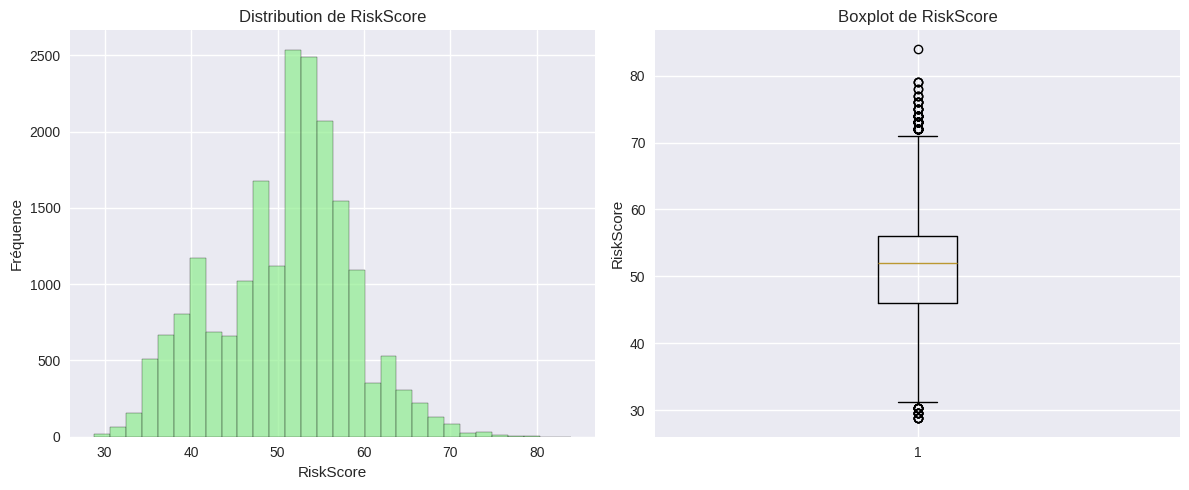


Statistiques de RiskScore:
  Moyenne: 50.767
  Médiane: 52.000
  Écart-type: 7.778
  Min: 28.800
  Max: 84.000


In [37]:
# Distribution de la variable cible
print("=== DISTRIBUTION DE LA VARIABLE CIBLE ===")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df[target_col].dropna(), bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title(f'Distribution de {target_col}')
plt.xlabel(target_col)
plt.ylabel('Fréquence')

plt.subplot(1, 2, 2)
plt.boxplot(df[target_col].dropna(), vert=True)
plt.title(f'Boxplot de {target_col}')
plt.ylabel(target_col)

plt.tight_layout()
plt.show()

print(f"\nStatistiques de {target_col}:")
print(f"  Moyenne: {df[target_col].mean():.3f}")
print(f"  Médiane: {df[target_col].median():.3f}")
print(f"  Écart-type: {df[target_col].std():.3f}")
print(f"  Min: {df[target_col].min():.3f}")
print(f"  Max: {df[target_col].max():.3f}")

## Distribution des Variables Numériques et Catégorielles

Maintenant on regarde comment chaque variable est distribuée. C'est crucial pour savoir si on doit transformer certaines variables avant de faire nos modèles.

**Utilité pour la Régression Quantile :**
- Si une variable est très asymétrique, on pourrait avoir besoin de la transformer (log, racine carrée, etc.)
- On peut repérer des patterns non-linéaires qui affectent différemment les quantiles
- Les outliers n'ont pas le même impact sur la médiane (quantile 0.5, robuste) que sur les quantiles extrêmes (0.9, très sensible)

**Utilité pour la Prédiction Conforme :**
- Normaliser les variables aide à construire un meilleur modèle de base
- Les variables avec beaucoup de bruit peuvent augmenter l'incertitude de nos prédictions
- Il faut que les features soient sur la même échelle pour que les scores de non-conformité soient comparables


=== DISTRIBUTIONS DES VARIABLES NUMÉRIQUES ===


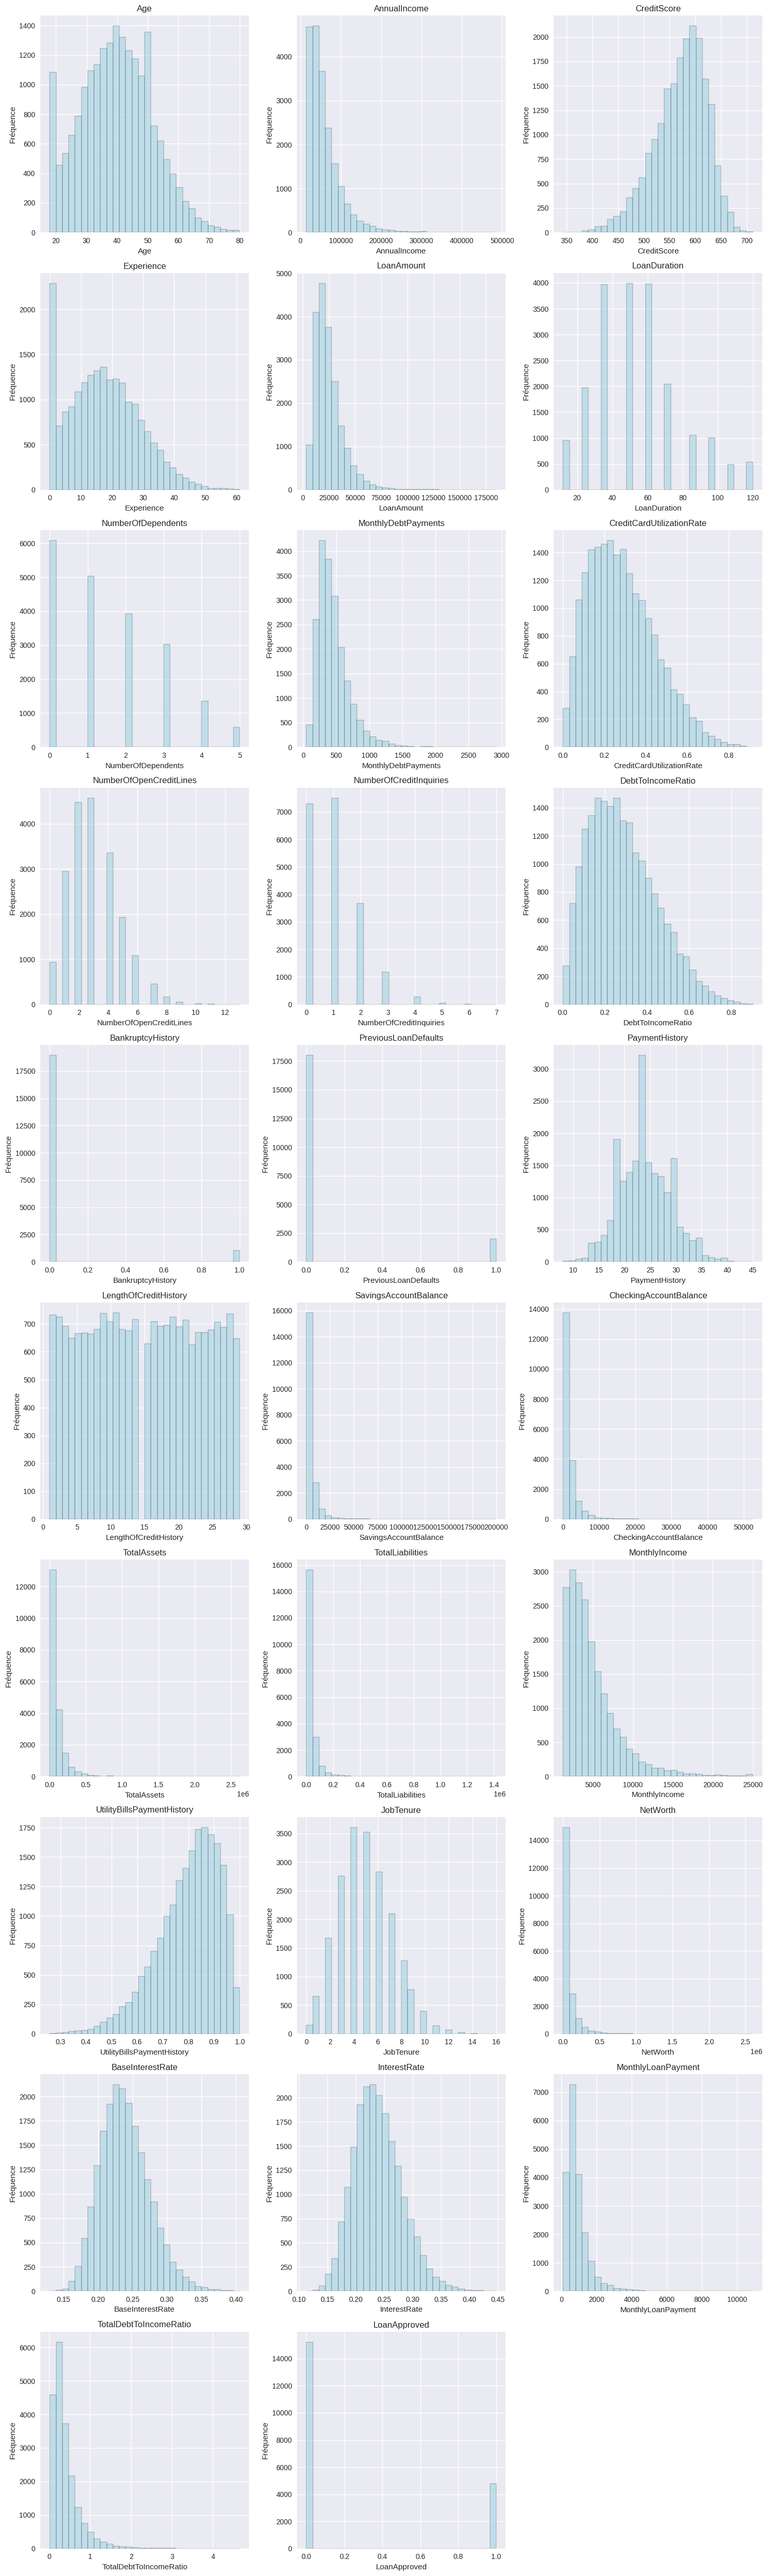

In [38]:
# Distributions des variables numériques explicatives
if len(numeric_features) > 0:
    print("\n=== DISTRIBUTIONS DES VARIABLES NUMÉRIQUES ===")
    
    n_cols = 3
    n_rows = (len(numeric_features) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5*n_rows))
    
    if len(numeric_features) == 1:
        axes = [axes]
    else:
        axes = axes.ravel()
    
    for i, col in enumerate(numeric_features):
        if i < len(axes):
            axes[i].hist(df[col].dropna(), bins=30, alpha=0.7, color='lightblue', edgecolor='black')
            axes[i].set_title(f'{col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Fréquence')
    
    # Masquer les axes vides
    for i in range(len(numeric_features), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
else:
    print("Aucune variable numérique explicative trouvée.")


=== DISTRIBUTIONS DES VARIABLES CATÉGORIELLES ===


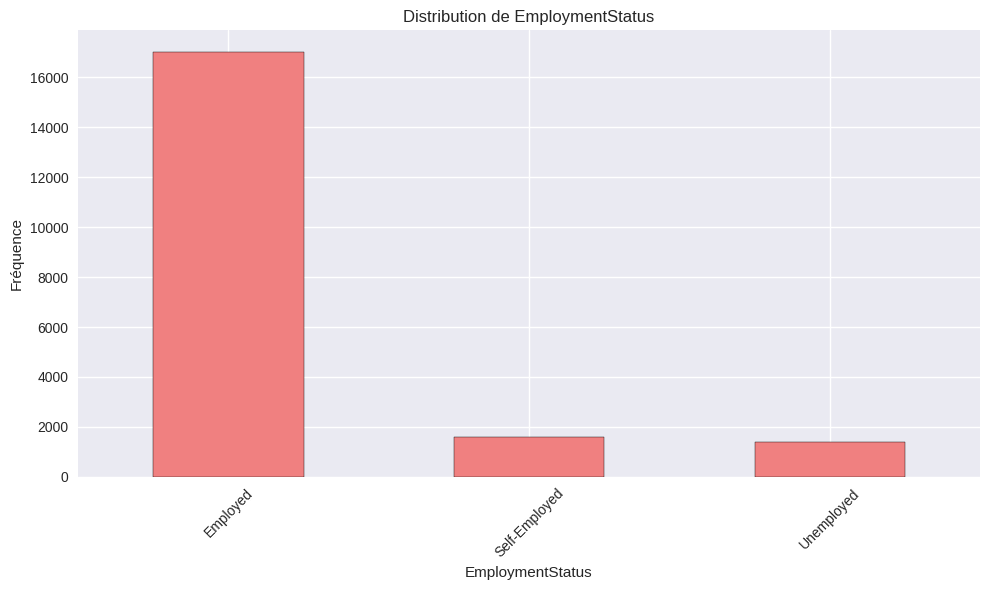


Répartition de EmploymentStatus:
  Employed: 17036 (85.2%)
  Self-Employed: 1573 (7.9%)
  Unemployed: 1391 (7.0%)


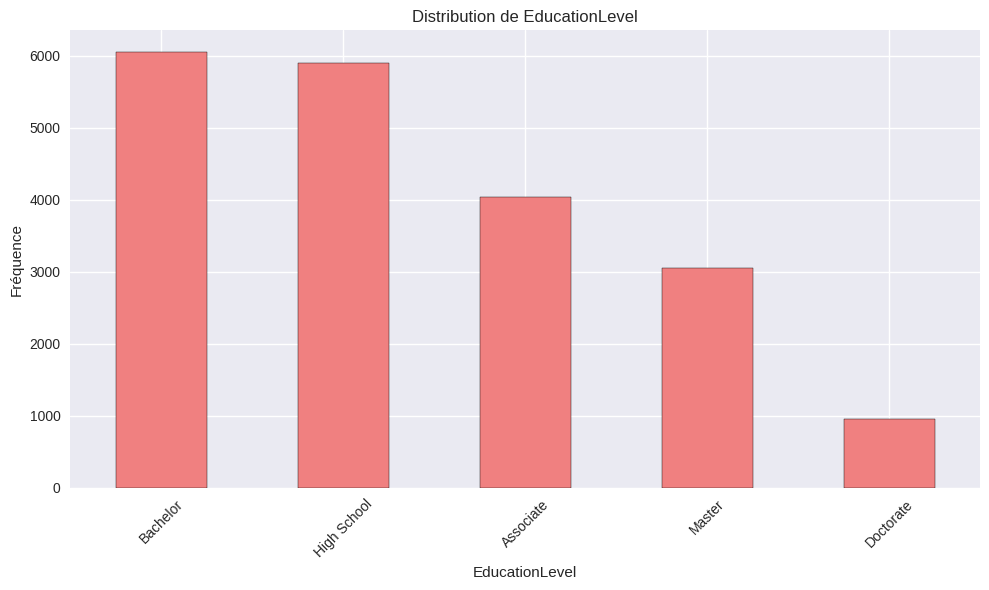


Répartition de EducationLevel:
  Bachelor: 6054 (30.3%)
  High School: 5908 (29.5%)
  Associate: 4034 (20.2%)
  Master: 3050 (15.2%)
  Doctorate: 954 (4.8%)


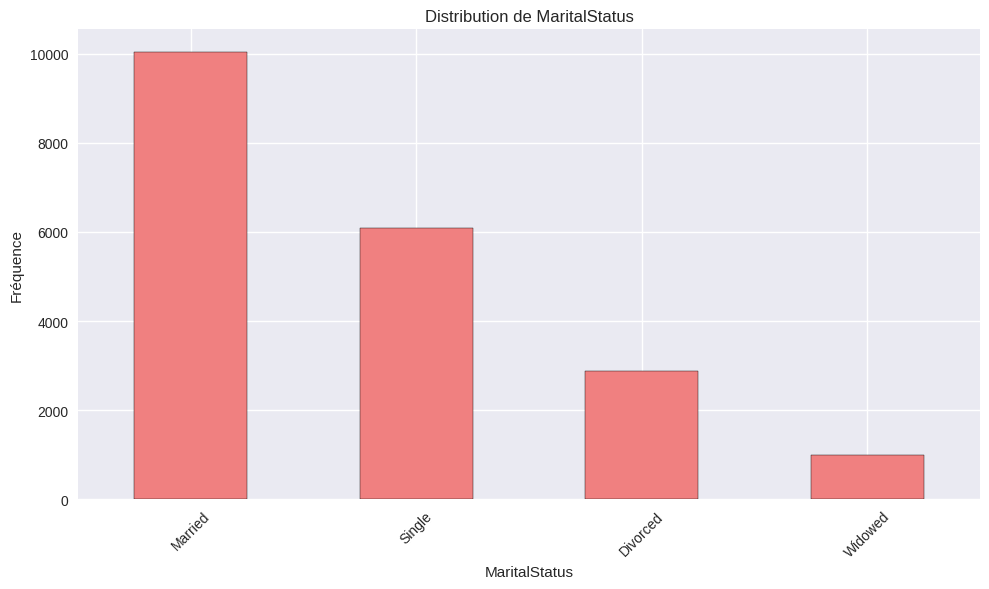


Répartition de MaritalStatus:
  Married: 10041 (50.2%)
  Single: 6078 (30.4%)
  Divorced: 2882 (14.4%)
  Widowed: 999 (5.0%)


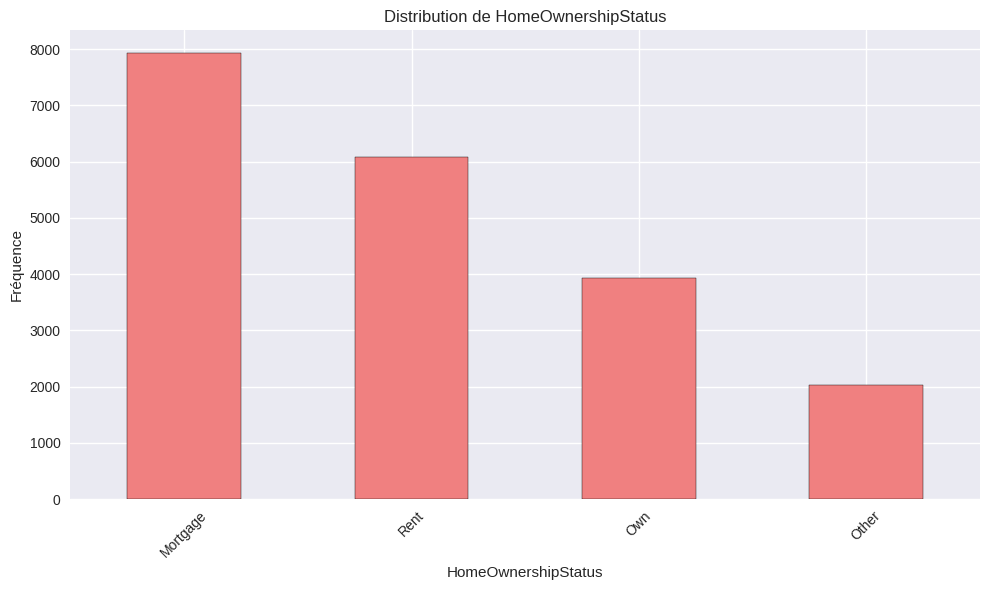


Répartition de HomeOwnershipStatus:
  Mortgage: 7939 (39.7%)
  Rent: 6087 (30.4%)
  Own: 3938 (19.7%)
  Other: 2036 (10.2%)


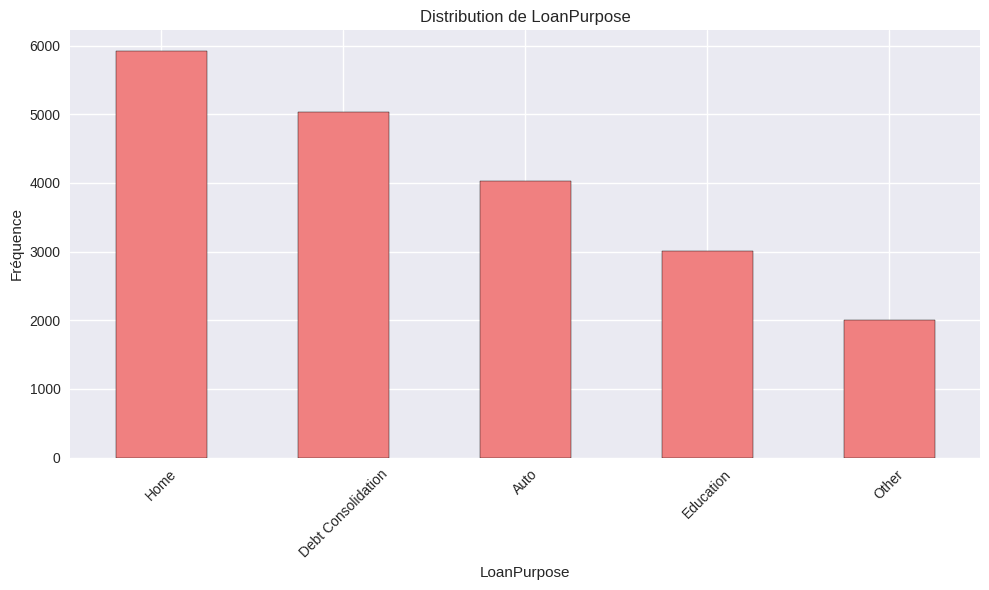


Répartition de LoanPurpose:
  Home: 5925 (29.6%)
  Debt Consolidation: 5027 (25.1%)
  Auto: 4034 (20.2%)
  Education: 3008 (15.0%)
  Other: 2006 (10.0%)


In [39]:
# Distributions des variables catégorielles
if len(categorical_cols) > 0:
    print("\n=== DISTRIBUTIONS DES VARIABLES CATÉGORIELLES ===")
    
    for col in categorical_cols:
        plt.figure(figsize=(10, 6))
        value_counts = df[col].value_counts()
        
        value_counts.plot(kind='bar', color='lightcoral', edgecolor='black')
        plt.title(f'Distribution de {col}')
        plt.xlabel(col)
        plt.ylabel('Fréquence')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        print(f"\nRépartition de {col}:")
        for value, count in value_counts.items():
            print(f"  {value}: {count} ({count/len(df)*100:.1f}%)")
else:
    print("Aucune variable catégorielle trouvée.")

## Matrice de Corrélation Globale

Cette matrice nous montre comment toutes les variables numériques sont corrélées entre elles. C'est utile pour détecter la multicolinéarité (quand deux variables donnent la même information).


=== MATRICE DE CORRÉLATION ===


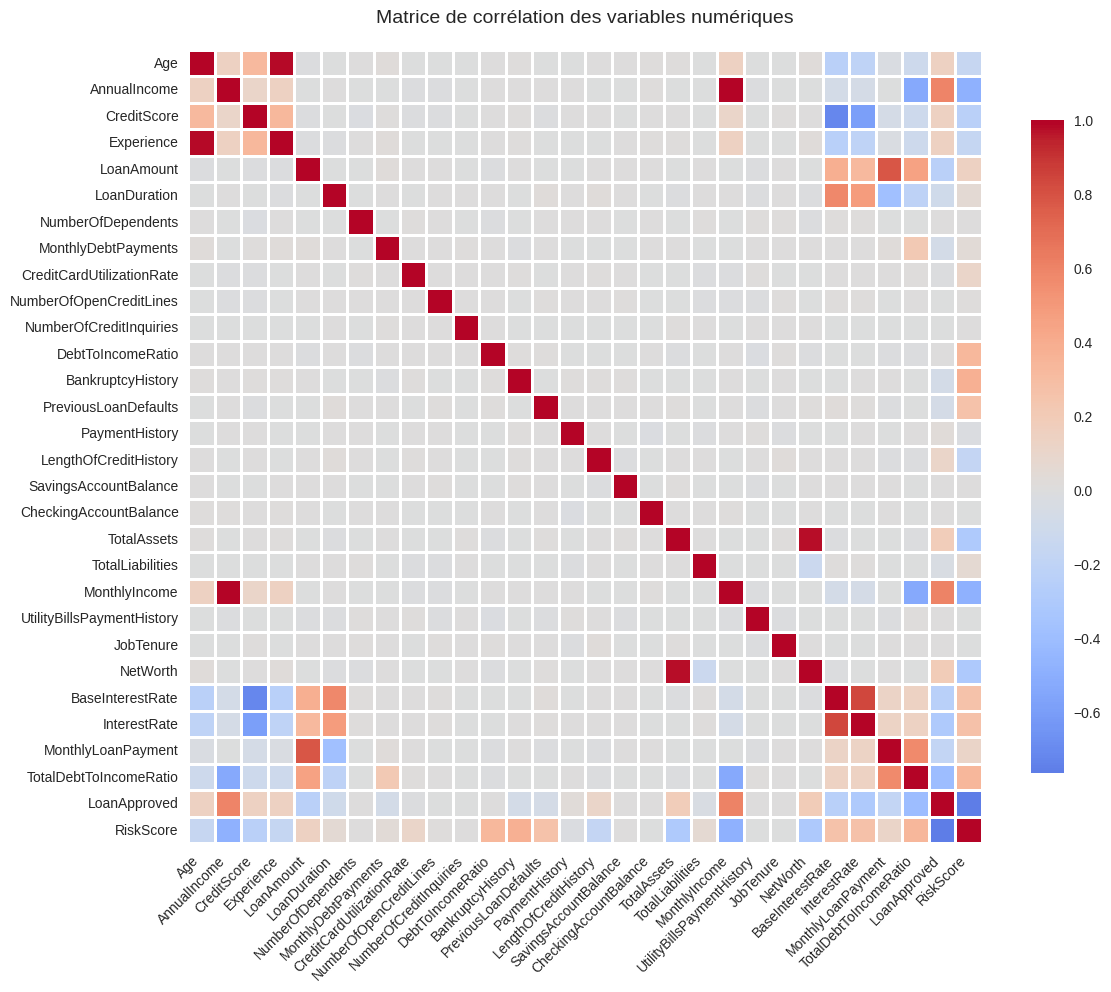


Top 10 des corrélations les plus fortes (hors diagonale):
  1. MonthlyIncome <-> AnnualIncome: 0.990
  2. Experience <-> Age: 0.983
  3. NetWorth <-> TotalAssets: 0.979
  4. InterestRate <-> BaseInterestRate: 0.835
  5. MonthlyLoanPayment <-> LoanAmount: 0.781
  6. RiskScore <-> LoanApproved: -0.766
  7. BaseInterestRate <-> CreditScore: -0.723
  8. LoanApproved <-> MonthlyIncome: 0.604
  9. InterestRate <-> CreditScore: -0.599
  10. LoanApproved <-> AnnualIncome: 0.598


In [40]:
# Matrice de corrélation
if len(numeric_cols) > 1:
    print("\n=== MATRICE DE CORRÉLATION ===")
    
    # Calculer la matrice de corrélation
    corr_matrix = df[numeric_cols].corr()
    
    # Afficher la heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, 
                fmt='.2f', 
                cmap='coolwarm', 
                center=0,
                square=True,
                linewidths=1,
                cbar_kws={"shrink": 0.8})
    plt.title('Matrice de corrélation des variables numériques', fontsize=14, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Afficher les corrélations les plus fortes (hors diagonale)
    print("\nTop 10 des corrélations les plus fortes (hors diagonale):")
    # Extraire le triangle supérieur de la matrice
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    # Convertir en série et trier
    correlations_list = upper_triangle.unstack().dropna().abs().sort_values(ascending=False)
    
    for i, ((var1, var2), corr_val) in enumerate(correlations_list.head(10).items()):
        actual_corr = corr_matrix.loc[var1, var2]
        print(f"  {i+1}. {var1} <-> {var2}: {actual_corr:.3f}")
else:
    print("Pas assez de variables numériques pour une matrice de corrélation.")

## Analyse Bivariée : Relation entre chaque Feature et la Cible

Ici, on compare chaque variable à notre variable cible (RiskScore) une par une. C'est super important parce que :

- On peut voir si la variance de Y change avec X (hétéroscédasticité) - crucial pour la régression quantile
- On identifie si l'effet d'une variable change selon le quantile qu'on regarde
- Les features fortement corrélées avec la cible vont améliorer notre modèle
- On repère les zones où l'incertitude est plus élevée


=== ANALYSE BIVARIÉE : VARIABLES NUMÉRIQUES vs CIBLE ===


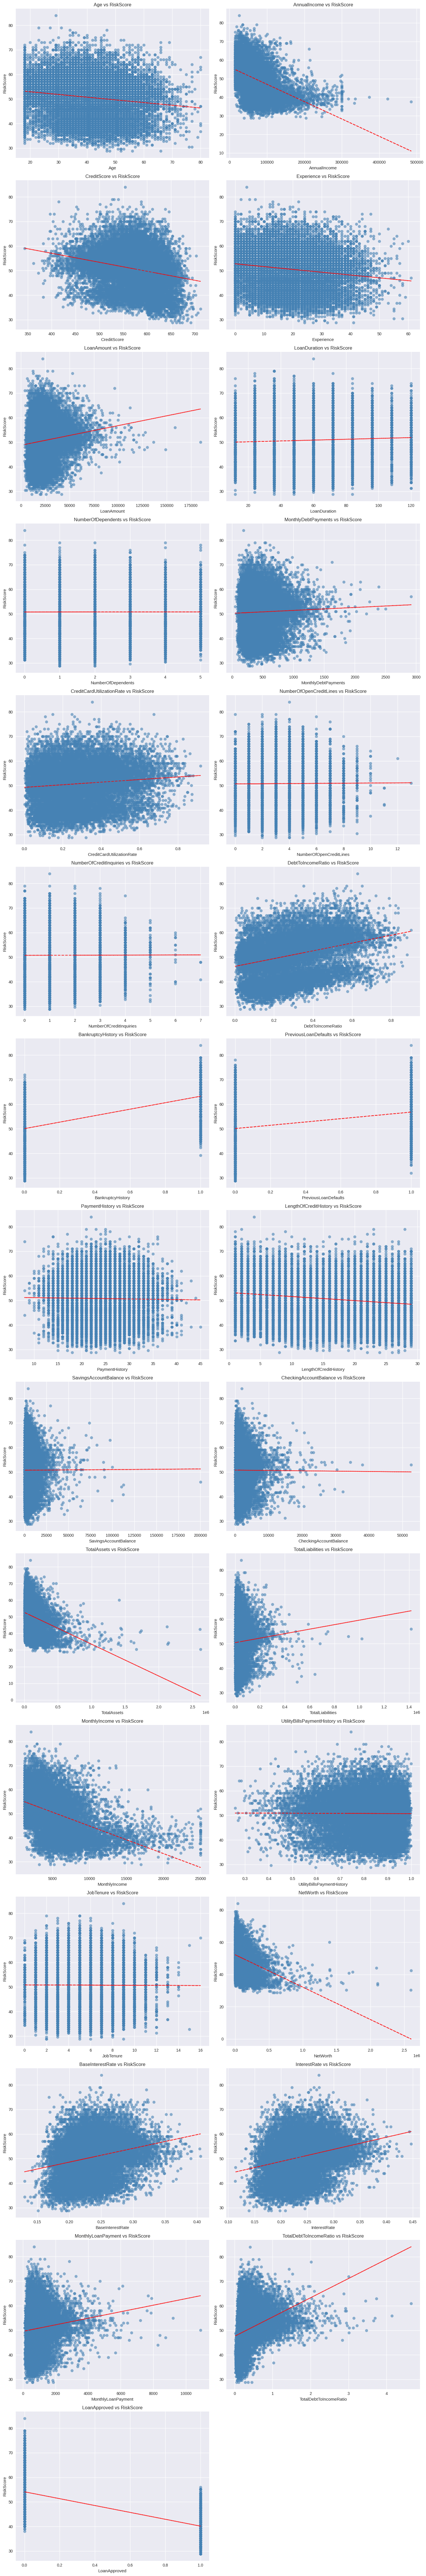


Corrélations avec RiskScore:
  LoanApproved: -0.766
  MonthlyIncome: -0.487
  AnnualIncome: -0.483
  BankruptcyHistory: 0.378
  TotalDebtToIncomeRatio: 0.343
  DebtToIncomeRatio: 0.327
  NetWorth: -0.304
  TotalAssets: -0.297
  InterestRate: 0.268
  PreviousLoanDefaults: 0.259
  BaseInterestRate: 0.256
  CreditScore: -0.240
  LengthOfCreditHistory: -0.178
  Experience: -0.166
  Age: -0.164
  LoanAmount: 0.138
  MonthlyLoanPayment: 0.116
  CreditCardUtilizationRate: 0.109
  TotalLiabilities: 0.056
  LoanDuration: 0.055
  MonthlyDebtPayments: 0.037
  PaymentHistory: -0.017
  NumberOfOpenCreditLines: 0.008
  UtilityBillsPaymentHistory: -0.005
  JobTenure: -0.004
  CheckingAccountBalance: -0.004
  NumberOfCreditInquiries: 0.003
  SavingsAccountBalance: 0.002
  NumberOfDependents: 0.002


In [41]:
# Analyse bivariée - Variables numériques vs Cible
if len(numeric_features) > 0:
    print("\n=== ANALYSE BIVARIÉE : VARIABLES NUMÉRIQUES vs CIBLE ===")
    
    n_cols = 2
    n_rows = (len(numeric_features) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 6*n_rows))
    
    if len(numeric_features) == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.ravel()
    
    for i, col in enumerate(numeric_features):
        if i < len(axes):
            # Scatter plot
            axes[i].scatter(df[col], df[target_col], alpha=0.6, color='steelblue')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel(target_col)
            axes[i].set_title(f'{col} vs {target_col}')
            
            # Ajouter une ligne de tendance
            z = np.polyfit(df[col].dropna(), df[target_col][df[col].notna()], 1)
            p = np.poly1d(z)
            axes[i].plot(df[col], p(df[col]), "r--", alpha=0.8)
    
    # Masquer les axes vides
    for i in range(len(numeric_features), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Corrélations avec la cible
    print(f"\nCorrélations avec {target_col}:")
    correlations = df[numeric_features + [target_col]].corr()[target_col].drop(target_col)
    correlations_sorted = correlations.abs().sort_values(ascending=False)
    
    for var in correlations_sorted.index:
        corr_val = correlations[var]
        print(f"  {var}: {corr_val:.3f}")
else:
    print("Aucune variable numérique pour l'analyse bivariée.")


=== ANALYSE BIVARIÉE : VARIABLES CATÉGORIELLES vs CIBLE ===

EmploymentStatus vs RiskScore:
Statistiques par groupe:
                  count    mean  median    std
EmploymentStatus                              
Employed          17036  50.351    51.0  7.681
Self-Employed      1573  52.456    54.0  8.048
Unemployed         1391  53.948    55.0  7.658


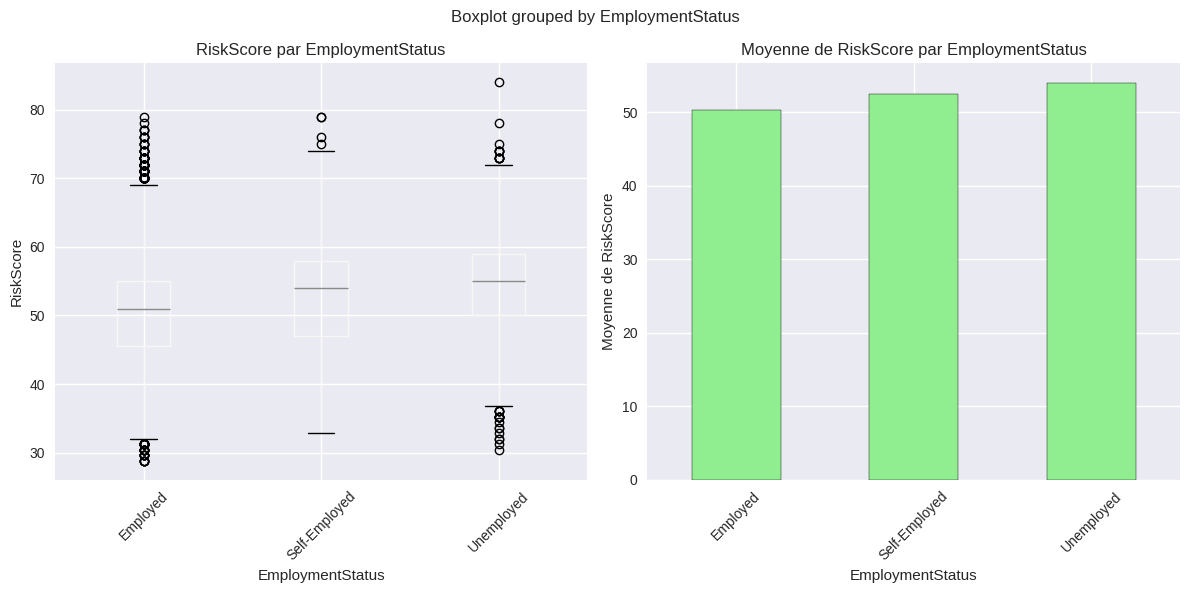


EducationLevel vs RiskScore:
Statistiques par groupe:
                count    mean  median    std
EducationLevel                              
Associate        4034  51.343    52.0  7.419
Bachelor         6054  50.325    51.0  7.978
Doctorate         954  47.584    48.0  8.670
High School      5908  52.214    53.0  6.970
Master           3050  49.073    50.0  8.314


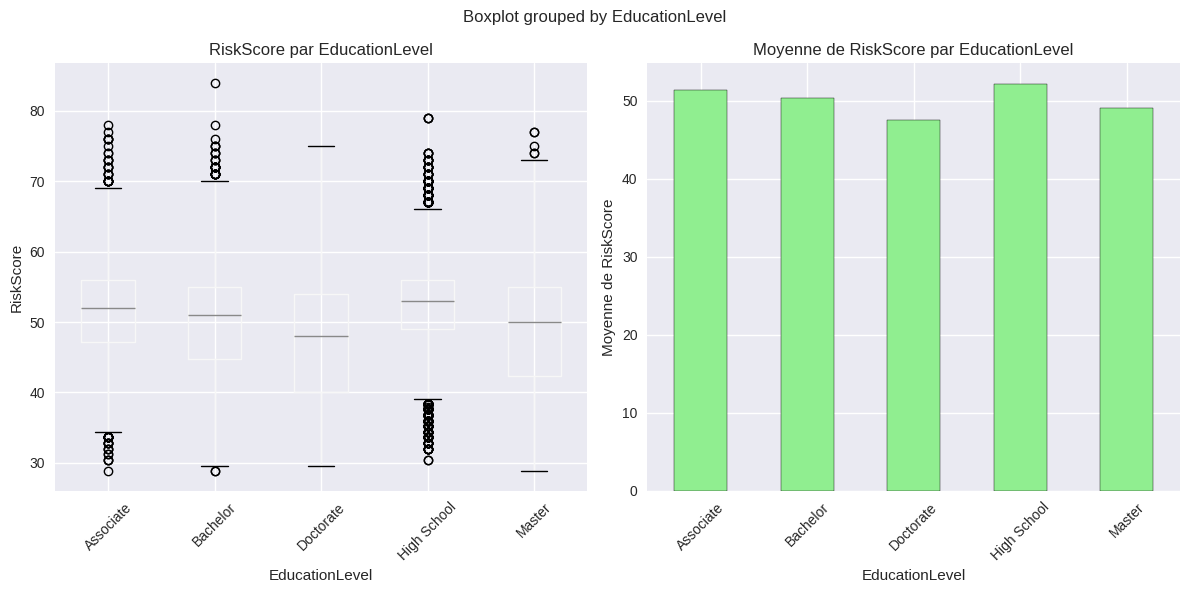


MaritalStatus vs RiskScore:
Statistiques par groupe:
               count    mean  median    std
MaritalStatus                              
Divorced        2882  50.522    52.0  7.752
Married        10041  50.736    52.0  7.742
Single          6078  50.890    52.0  7.851
Widowed          999  51.037    52.0  7.759


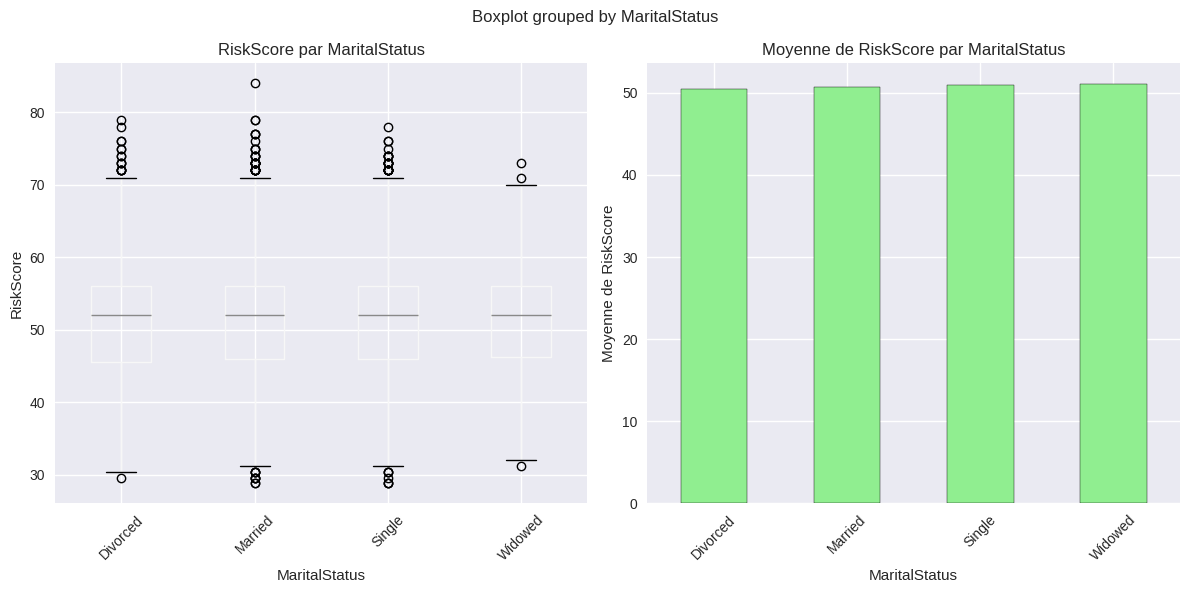


HomeOwnershipStatus vs RiskScore:
Statistiques par groupe:
                     count    mean  median    std
HomeOwnershipStatus                              
Mortgage              7939  50.688    52.0  7.808
Other                 2036  51.090    52.0  7.575
Own                   3938  50.685    52.0  7.883
Rent                  6087  50.815    52.0  7.737


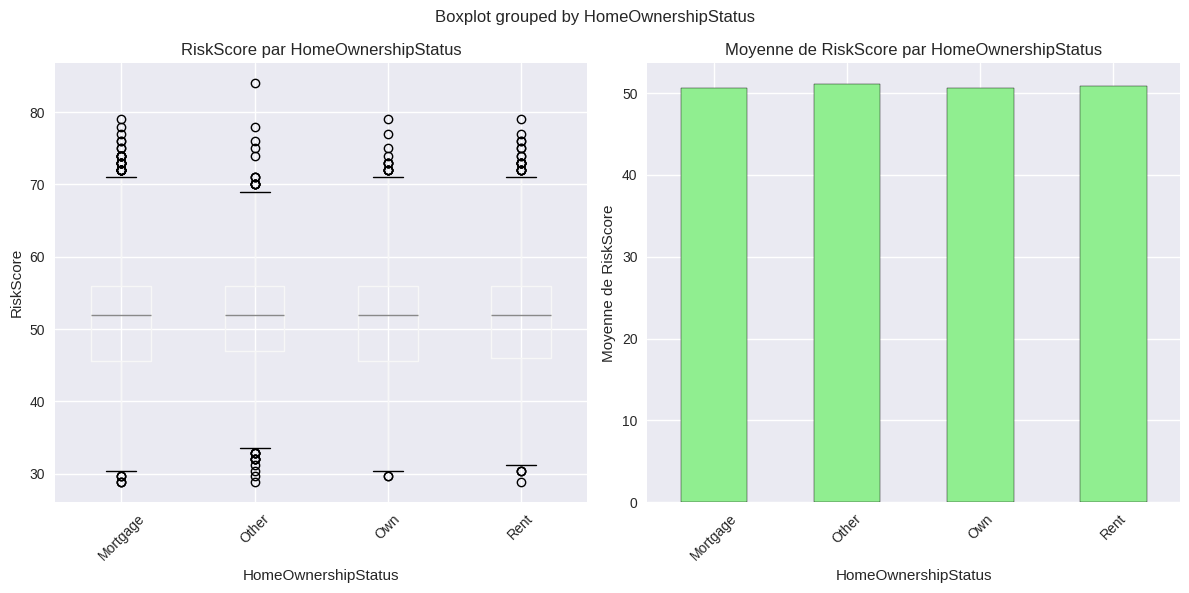


LoanPurpose vs RiskScore:
Statistiques par groupe:
                    count    mean  median    std
LoanPurpose                                     
Auto                 4034  50.643    52.0  7.756
Debt Consolidation   5027  50.946    52.0  7.821
Education            3008  50.505    51.0  7.770
Home                 5925  50.721    52.0  7.760
Other                2006  51.092    52.0  7.771


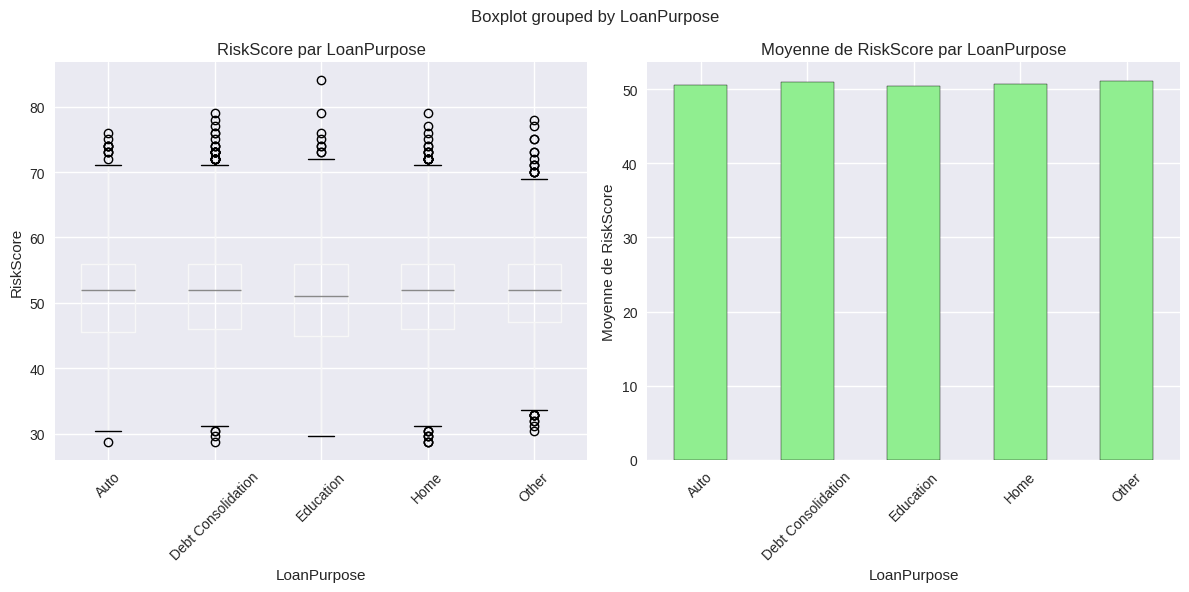

In [42]:
# Analyse bivariée - Variables catégorielles vs Cible
if len(categorical_cols) > 0:
    print("\n=== ANALYSE BIVARIÉE : VARIABLES CATÉGORIELLES vs CIBLE ===")
    
    for col in categorical_cols:
        print(f"\n{col} vs {target_col}:")
        
        # Statistiques par groupe
        stats_by_group = df.groupby(col)[target_col].agg(['count', 'mean', 'median', 'std']).round(3)
        print("Statistiques par groupe:")
        print(stats_by_group)
        
        # Boxplot par catégorie
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        df.boxplot(column=target_col, by=col, ax=plt.gca())
        plt.title(f'{target_col} par {col}')
        plt.xlabel(col)
        plt.ylabel(target_col)
        plt.xticks(rotation=45)
        
        plt.subplot(1, 2, 2)
        # Barplot des moyennes
        means = df.groupby(col)[target_col].mean()
        means.plot(kind='bar', color='lightgreen', edgecolor='black')
        plt.title(f'Moyenne de {target_col} par {col}')
        plt.xlabel(col)
        plt.ylabel(f'Moyenne de {target_col}')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
else:
    print("Aucune variable catégorielle pour l'analyse bivariée.")

## Corrélations avec la Variable Cible

L'objectif ici est de mettre en évidence les features les plus corrélées (positivement ou négativement) avec notre variable cible. 

Ça nous permettra par exemple de :
- Ignorer certaines features peu utiles pour améliorer nos modèles de prédiction conforme
- Sélectionner les features les plus pertinentes pour visualiser une régression quantile en 2D
- Comprendre quelles variables ont le plus d'influence sur le risque de crédit


=== CORRÉLATIONS DES FEATURES AVEC LA VARIABLE CIBLE ===


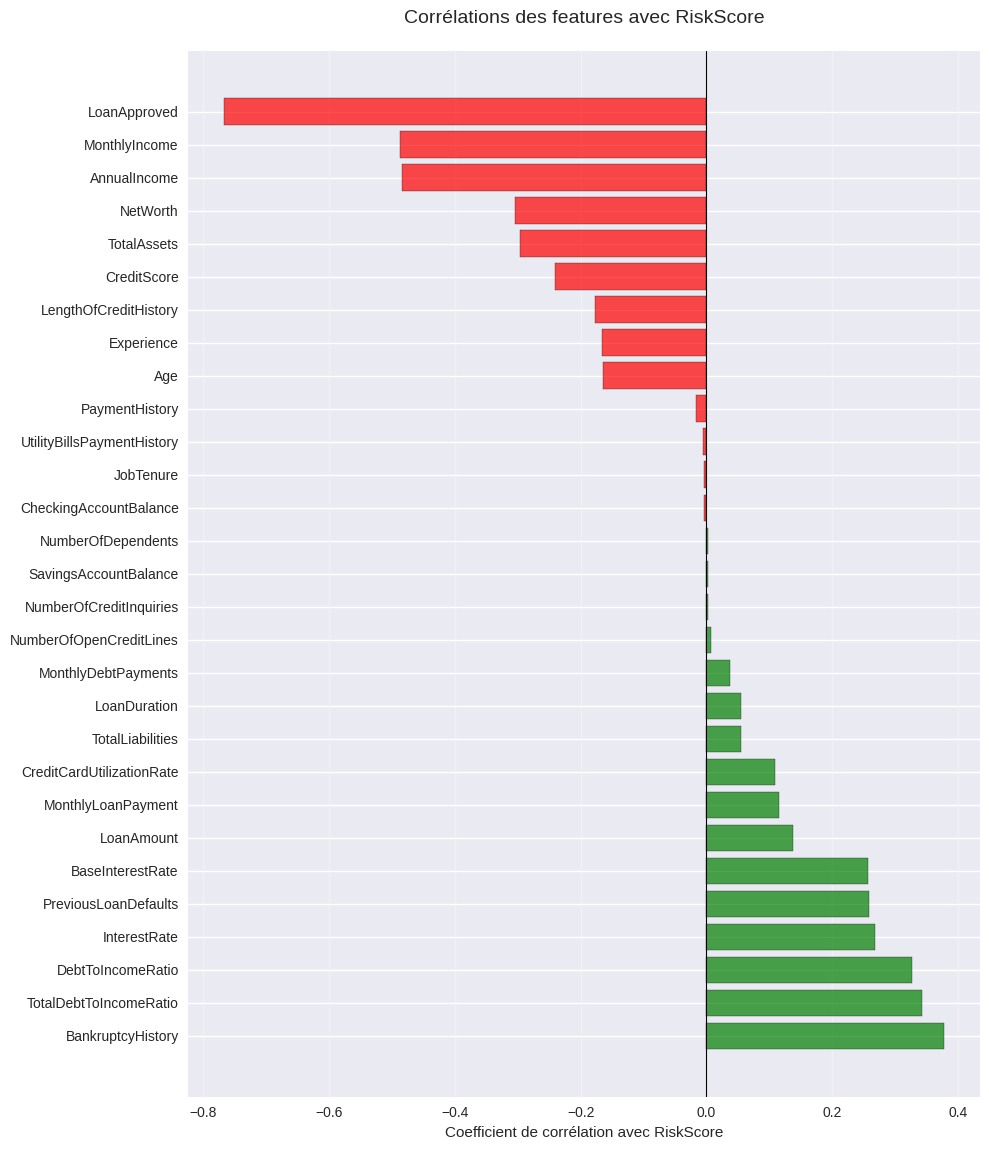


Corrélations avec RiskScore (triées par valeur absolue décroissante):
  LoanApproved: -0.766
  MonthlyIncome: -0.487
  AnnualIncome: -0.483
  BankruptcyHistory: 0.378
  TotalDebtToIncomeRatio: 0.343
  DebtToIncomeRatio: 0.327
  NetWorth: -0.304
  TotalAssets: -0.297
  InterestRate: 0.268
  PreviousLoanDefaults: 0.259
  BaseInterestRate: 0.256
  CreditScore: -0.240
  LengthOfCreditHistory: -0.178
  Experience: -0.166
  Age: -0.164
  LoanAmount: 0.138
  MonthlyLoanPayment: 0.116
  CreditCardUtilizationRate: 0.109
  TotalLiabilities: 0.056
  LoanDuration: 0.055
  MonthlyDebtPayments: 0.037
  PaymentHistory: -0.017
  NumberOfOpenCreditLines: 0.008
  UtilityBillsPaymentHistory: -0.005
  JobTenure: -0.004
  CheckingAccountBalance: -0.004
  NumberOfCreditInquiries: 0.003
  SavingsAccountBalance: 0.002
  NumberOfDependents: 0.002


In [44]:
# Matrice de corrélation des features avec la variable cible
if len(numeric_features) > 0:
    print("\n=== CORRÉLATIONS DES FEATURES AVEC LA VARIABLE CIBLE ===")
    
    # Calculer les corrélations avec la cible
    correlations_with_target = df[numeric_features + [target_col]].corr()[target_col].drop(target_col)
    correlations_sorted = correlations_with_target.sort_values(ascending=False)
    
    # Visualisation avec barplot horizontal
    plt.figure(figsize=(10, max(6, len(numeric_features) * 0.4)))
    colors = ['green' if x > 0 else 'red' for x in correlations_sorted.values]
    
    plt.barh(range(len(correlations_sorted)), correlations_sorted.values, color=colors, alpha=0.7, edgecolor='black')
    plt.yticks(range(len(correlations_sorted)), correlations_sorted.index)
    plt.xlabel('Coefficient de corrélation avec ' + target_col)
    plt.title(f'Corrélations des features avec {target_col}', fontsize=14, pad=20)
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Afficher les valeurs numériques
    print(f"\nCorrélations avec {target_col} (triées par valeur absolue décroissante):")
    correlations_abs_sorted = correlations_with_target.abs().sort_values(ascending=False)
    
    for var in correlations_abs_sorted.index:
        corr_val = correlations_with_target[var]
        abs_corr = abs(corr_val)
        print(f"  {var}: {corr_val:.3f}")
else:
    print("Aucune variable numérique pour calculer les corrélations avec la cible.")

### Interprétation des Corrélations

D'après la matrice de corrélation ci-dessus, on peut tirer plusieurs conclusions importantes :

**Features fortement corrélées positivement** (en vert) :
- Ces variables augmentent le RiskScore quand elles augmentent
- Ce sont probablement des facteurs de risque aggravants (par exemple : ratio dette/revenu élevé, nombre de crédits existants, etc.)
- Elles seront particulièrement importantes pour prédire les quantiles élevés (clients à haut risque)

**Features corrélées négativement** (en rouge) :
- Ces variables font diminuer le RiskScore quand elles augmentent
- Ce sont des facteurs protecteurs (par exemple : revenus élevés, historique de crédit positif, etc.)
- Elles aident à identifier les clients à faible risque

**Features peu corrélées** (proche de 0) :
- Ces variables ont une relation faible ou non-linéaire avec le risque
- On pourrait envisager de les exclure pour simplifier nos modèles
- Attention : une faible corrélation linéaire ne signifie pas forcément qu'elles sont inutiles !

**Pour la suite du projet :**
- On va se concentrer sur les features avec |corrélation| > 0.3 pour la régression quantile
- Pour la prédiction conforme, on testera avec et sans les features faiblement corrélées dans l'espoir d'améliorer le taux de couverture.